# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [3]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

from scipy.sparse import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [4]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)

test_data, test_labels = newsgroups_test.data[num_test//2:], newsgroups_test.target[num_test//2:]
dev_data, dev_labels = newsgroups_test.data[:num_test//2], newsgroups_test.target[:num_test//2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print ('training label shape:', train_labels.shape)
print ('test label shape:', test_labels.shape)
print ('dev label shape:', dev_labels.shape)
print ('labels names:', newsgroups_train.target_names)

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

In [42]:
def P1(num_examples=5):
### STUDENT START ###
    for i in range(num_examples):
        print ('\nEXAMPLE %d\nLABEL:  \t%s' % (i+1, categories[train_labels[i]]))
        print ('MESSAGE:\n\n%s' % train_data[i])
        print ('\n')
    
### STUDENT END ###
P1()


EXAMPLE 1
LABEL:  	talk.religion.misc
MESSAGE:

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych



EXAMPLE 2
LABEL:  	sci.space
MESSAGE:



Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such e

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [155]:
def P2():
### STUDENT START ###

    # Initialize vectorizer
    vectorizer = CountVectorizer()
    # Fit model
    X = vectorizer.fit_transform(train_data)
    print('Shape of X', X.shape, '\n')
    
    print('a.) Size of the vocabulary is %0d' % X.shape[1])
    print('    Average number of non-zero features is %0.2f' % np.mean(X.getnnz(axis=1)))
    Total_Size=X.shape[0]*X.shape[1]
    print('    Fraction of entries that are non-zero is %0.2f%%' % (100*float(X.getnnz()/Total_Size)))
    print('\n')
    
    # Get feature names
    names = vectorizer.get_feature_names() 
    print('b.) 0th feature string is %s' % names[0])
    print('    Last feature string is %s' % names[len(names)-1])
    print('\n')
    
    # Set up new vocabulary
    my_vocabulary = ["atheism", "graphics", "space", "religion"]
    # Set new vocabulary of Vectorizer
    vectorizer.set_params(vocabulary=my_vocabulary)
    X_vocab = vectorizer.fit_transform(train_data)
    print('c.) The feature names are %s' % vectorizer.get_feature_names())
    print('    Shape is', X_vocab.shape)
    print('    Avg number of non-zero features is %02f' % np.mean(X_vocab.getnnz(axis=1)))
    print('\n')
    
    # Extract bigram and trigram character features
    vectorizer.set_params(analyzer='char', ngram_range=(2,2), vocabulary=None)
    X_bigram = vectorizer.fit_transform(train_data)
    print('d.) Unbounded Bigram Shape is', X_bigram.shape)
    vectorizer.set_params(analyzer='char_wb', ngram_range=(2,2))
    X_bigramwb = vectorizer.fit_transform(train_data)
    print('    Word Bound Bigram Shape is', X_bigramwb.shape)
    vectorizer.set_params(analyzer='char', ngram_range=(3,3))
    X_trigram = vectorizer.fit_transform(train_data)
    print('    Unbounded Trigram Shape is', X_trigram.shape)    
    vectorizer.set_params(analyzer='char_wb', ngram_range=(3,3))
    X_trigramwb = vectorizer.fit_transform(train_data)
    print('    Word Bound Trigram Shape is', X_trigramwb.shape)    
    print('\n')
    
    # Use "min_df" to prune words that appear in fewer than 10 documents
    vectorizer.set_params(analyzer='word', ngram_range=(1,1))
    vectorizer.set_params(min_df=10)
    X_prune = vectorizer.fit_transform(train_data)
    print('e.) Size of vocabulary when pruned is', X_prune.shape[1])
    print('\n')
    
    # fraction of the words in the dev data missing from the vocabulary
    vectorizer.set_params(min_df=1)
    dev_vocab = vectorizer.fit_transform(dev_data)
    dev_names = vectorizer.get_feature_names()
    diff_size = len(set(dev_names) - set(names))
    print('f.) Words missing in dev %d, Fraction is %0.1f%%'\
          % (diff_size,100*diff_size/ float(len(dev_names))))   
    
### STUDENT END ###
P2()

Shape of X (2034, 26879) 

a.) Size of the vocabulary is 26879
    Average number of non-zero features is 96.71
    Fraction of entries that are non-zero is 0.36%


b.) 0th feature string is 00
    Last feature string is zyxel


c.) The feature names are ['atheism', 'graphics', 'space', 'religion']
    Shape is (2034, 4)
    Avg number of non-zero features is 0.268437


d.) Unbounded Bigram Shape is (2034, 3291)
    Word Bound Bigram Shape is (2034, 3090)
    Unbounded Trigram Shape is (2034, 32187)
    Word Bound Trigram Shape is (2034, 25864)


e.) Size of vocabulary when pruned is 3064


f.) Words missing in dev 4027, Fraction is 24.8%


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

In [10]:
def P3():
### STUDENT START ###
    vectorizer = CountVectorizer()
    train_matrix = vectorizer.fit_transform(train_data)
    dev_matrix = vectorizer.transform(dev_data)
    
    # KNN classifier
    #----------------
    neighbors = {'n_neighbors': list(range(5,100,5))}
    
    nbrs = GridSearchCV(KNeighborsClassifier(), neighbors, scoring='accuracy')
    nbrs.fit(train_matrix, train_labels)
    
    print("K-nearest Neighbors")
    print("    Best Parameter:\t\t", nbrs.best_params_)
    print("    Best f1 Score:\t\t%0.3f" % nbrs.best_score_)
    print("    f1 Score on Dev Data:\t%0.3f" % \
          metrics.f1_score(dev_labels, nbrs.predict(dev_matrix), \
                           average='macro'))

    # NB classifier
    #---------------
    alphas = {'alpha' : (0, 0.0001, 0.001, 0.01, 0.1)}
    
    nb = GridSearchCV(MultinomialNB(), alphas, scoring='accuracy')
    nb.fit(train_matrix, train_labels)
    
    print("Multinomial NB")
    print("    Best Parameter:\t\t", nb.best_params_)
    print("    Best f1 Score:\t\t%0.3f" % nb.best_score_)
    print("    f1 Score on Dev Data:\t%0.3f" % \
          metrics.f1_score(dev_labels, nb.predict(dev_matrix), \
                           average='macro'))
    
    # Logistic regression
    #---------------------
    Cs = {'C' : (0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 1, 2)}
    
    lr = GridSearchCV(LogisticRegression(penalty='l2'),\
                      Cs, scoring='accuracy')
    lr.fit(train_matrix, train_labels)
    
    print("Logistic Regression")
    print("    Best Parameter:\t\t", lr.best_params_)
    print("    Best f1 Score:\t\t%0.3f" % lr.best_score_)
    print("    f1 Score on Dev Data:\t%0.3f" % \
          metrics.f1_score(dev_labels, lr.predict(dev_matrix), \
                           average='macro'))

    # Printing sum of squared weights for each class
    print("\n")
    Cs = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 1, 2]
    for c in Cs:
        l_clf = LogisticRegression(penalty = 'l2', C = c)
        l_clf.fit(train_matrix, train_labels)
        l_clf_preds = l_clf.predict(dev_matrix)
     
        print("C setting:", c, ";\tSum of Squared weights:\t", np.sum(l_clf.coef_**2, axis=1))
        
### STUDENT END ###
P3()

K-nearest Neighbors
    Best Parameter:		 {'n_neighbors': 95}
    Best f1 Score:		0.442
    f1 Score on Dev Data:	0.438
Multinomial NB
    Best Parameter:		 {'alpha': 0.01}
    Best f1 Score:		0.828
    f1 Score on Dev Data:	0.755
Logistic Regression
    Best Parameter:		 {'C': 0.2}
    Best f1 Score:		0.776
    f1 Score on Dev Data:	0.688


C setting: 0.05 ;	Sum of Squared weights:	 [14.07317382 13.66910805 14.60408558 11.86068068]
C setting: 0.1 ;	Sum of Squared weights:	 [27.13276422 24.65876272 27.45791178 23.02092251]
C setting: 0.15 ;	Sum of Squared weights:	 [38.91468675 34.1860097  38.90897803 33.22437863]
C setting: 0.2 ;	Sum of Squared weights:	 [49.74773667 42.7390849  49.32844039 42.66847345]
C setting: 0.25 ;	Sum of Squared weights:	 [59.81736061 50.5711942  58.93543172 51.4556239 ]
C setting: 0.3 ;	Sum of Squared weights:	 [69.29668715 57.87171997 67.90306275 59.75911064]
C setting: 1 ;	Sum of Squared weights:	 [166.96406144 130.8904599  157.88282512 145.71125673]
C setti

ANSWER:

**a. Why doesn't nearest neighbors work well for this problem?**

_K nearest neighbors uses values of features to calculate distances between observations. In this case the words in the documents are used as features. We have seen in # 2.f above, almost 25% of the words in the dev data set are not there in the vocabulary. This mismatch in features results in poorer performance by K nearest neighbors algorithm. Also, this method doesn't work well because the feature set is sparse and highly multidimensional along with small training set_

**b. Any ideas why logistic regression doesn't work as well as Naive Bayes?**

_Logistic regresion doesn't work as well because the number of training examples is small in comparison with the number of features (2034 training examples vs 26879 features). The few training examples and high number of features make it relatively easier to estimate the joint probability (used in Naive Bayes) than the conditional probability used in logistic regression_

**c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.**

_C is the inverse of regularization strength so smaller values of C results in stronger regularization and hence smaller weights. So as C goes smaller the sum of the weights becomes smaller_

_With smaller C's we expect coefficients to be small (large penalties on large coefficients). Thus their sums of squares will be small_
_With larger C's we expect higher coefficients to be accepted, thus expect to see larger sums of squares_

_This is consistent with the resulting sum of square weights shown below._

In [11]:
vectorizer = CountVectorizer()
train_matrix = vectorizer.fit_transform(train_data)
for i in (0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 1, 2):
    lr = LogisticRegression(penalty='l2',C=i)
    lr.fit(train_matrix, train_labels)
    
    #Sum of squared weight values
    sum = np.sum(lr.coef_*lr.coef_, axis=1)
    print("For C = %0.2f, the square weights are [%s]" % (i, \
                    '  '.join("%0.2f" % j for j in sum)))


For C = 0.05, the square weights are [14.07  13.67  14.60  11.86]
For C = 0.10, the square weights are [27.13  24.66  27.46  23.02]
For C = 0.15, the square weights are [38.91  34.19  38.91  33.22]
For C = 0.20, the square weights are [49.75  42.74  49.33  42.67]
For C = 0.25, the square weights are [59.82  50.57  58.94  51.46]
For C = 0.30, the square weights are [69.30  57.87  67.90  59.76]
For C = 1.00, the square weights are [166.96  130.89  157.88  145.71]
For C = 2.00, the square weights are [257.63  197.94  239.97  226.71]


(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [118]:
def P4():
### STUDENT START ###
    vectorizer = CountVectorizer()
    train_matrix = vectorizer.fit_transform(train_data)
    lr = LogisticRegression()
    lr.fit(train_matrix, train_labels)
    
    # Get indices for 5 largest weights (use absolute value for weights)
    ind = np.argsort(np.absolute(lr.coef_),axis=1)[:,-5:]
                                        
    # Loop to print table
    for i in range(4):
        print ("\n  Category Label %s" % categories[i])
        print ("\t\t%s\t%s\t%s\t%s" % tuple(categories))
        for j in range(4,-1,-1):
            name = vectorizer.get_feature_names()[ind[i,j]]
            coef1, coef2, coef3, coef4 = lr.coef_[:,ind[i,j]]
            print ("%-10s\t %0.3f\t\t %0.3f\t\t\t %0.3f\t\t %0.3f" % (name, coef1, coef2, coef3, coef4))
   
    print("\n")
    print("BiGram output")
    print("==============")

    # Compute bigram
    vectorizer = CountVectorizer(ngram_range=(2, 2))
    train_matrix = vectorizer.fit_transform(train_data)
    lr = LogisticRegression()
    lr.fit(train_matrix, train_labels)
    
    # Get indices for 5 largest weights (use absolute value for weights)
    ind = np.argsort(np.absolute(lr.coef_),axis=1)[:,-5:]
                                        
    # Loop to print table
    for i in range(4):
        print ("\n  Category Label %s" % categories[i])
        print ("\t\t%s\t%s\t%s\t%s" % tuple(categories))
        for j in range(4,-1,-1):
            name = vectorizer.get_feature_names()[ind[i,j]]
            coef1, coef2, coef3, coef4 = lr.coef_[:,ind[i,j]]
            print ("%-10s\t %0.3f\t\t %0.3f\t\t\t %0.3f\t\t %0.3f" % (name, coef1, coef2, coef3, coef4))
            
### STUDENT END ###
P4()


  Category Label alt.atheism
		alt.atheism	talk.religion.misc	comp.graphics	sci.space
space     	 -1.260		 -1.316			 2.162		 -1.171
deletion  	 1.125		 -0.398			 -0.420		 -0.395
atheists  	 1.031		 -0.098			 -0.319		 -0.835
bobby     	 0.990		 -0.221			 -0.341		 -0.464
religion  	 0.954		 -0.617			 -0.793		 -0.064

  Category Label talk.religion.misc
		alt.atheism	talk.religion.misc	comp.graphics	sci.space
graphics  	 -0.758		 1.937			 -1.337		 -0.763
image     	 -0.583		 1.347			 -0.825		 -0.469
space     	 -1.260		 -1.316			 2.162		 -1.171
file      	 -0.335		 1.267			 -0.807		 -0.627
3d        	 -0.359		 1.125			 -0.702		 -0.378

  Category Label comp.graphics
		alt.atheism	talk.religion.misc	comp.graphics	sci.space
space     	 -1.260		 -1.316			 2.162		 -1.171
graphics  	 -0.758		 1.937			 -1.337		 -0.763
orbit     	 -0.414		 -0.672			 1.225		 -0.629
nasa      	 -0.573		 -0.480			 1.011		 -0.468
launch    	 -0.471		 -0.466			 0.937		 -0.333

  Category Label sci.space
		alt.atheis

ANSWER:

_There are several surprising Bigram features. Bigrams consisting of stop words are appearing in the top of the list_ <br>
* the moon positively related to comp.graphics but negatively related to sci.space
* sci space positively related to comp.graphics but not to sci.space
* comp graphics positively related to talk.religion.misc but not to comp.graphics

_For unigram features, we see_
* space positively related to comp.graphics
* graphics positively related to talk.religion.misc
* nasa positively related to comp.graphics


(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [16]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
### STUDENT START ###

    # Set everything to lowercase
    s = s.lower()
    # Discard non-letter or non-number characters
    s = re.sub("[^A-Za-z0-9 \\n]", " ", s)
    # Shorten long words to no more than 6 characters
    s = re.sub("(\w{%d})\w+" % 6, "\\1", s)
    # Replace sequences of numbers with " number " (a single token)
    s = re.sub("([\d]+)", " number ", s)
    
    return s
### STUDENT END ###

def P5():
### STUDENT START ###
    vectorizer = CountVectorizer()
    train_matrix = vectorizer.fit_transform(train_data)
    dev_matrix = vectorizer.transform(dev_data)
    lr = LogisticRegression()
    lr.fit(train_matrix, train_labels)
    dev_predict = lr.predict(dev_matrix)
        
    f1 = metrics.f1_score(dev_labels, dev_predict, average='macro')
    print("Default Preprocessor")
    print("Size is", len(vectorizer.get_feature_names()))
    print("F1-score is", f1)
    print("\n")

    # Use the empty pre-processor
    empty_vectorizer = CountVectorizer(preprocessor=empty_preprocessor)
    empty_train_matrix = empty_vectorizer.fit_transform(train_data)
    empty_dev_matrix = empty_vectorizer.transform(dev_data)
    lr2 = LogisticRegression()
    lr2.fit(empty_train_matrix, train_labels)
    empty_dev_predict = lr2.predict(empty_dev_matrix)
    
    f2 = metrics.f1_score(dev_labels, empty_dev_predict, average='macro')
    print("Empty Preprocessor")
    print("Size is", len(empty_vectorizer.get_feature_names()))
    print("F1-score is", f2)
    print("\n")
    
    # Use the better pre-processor
    better_vectorizer = CountVectorizer(preprocessor=better_preprocessor, stop_words='english')
    better_train_matrix = better_vectorizer.fit_transform(train_data)
    better_dev_matrix = better_vectorizer.transform(dev_data)
    lr3 = LogisticRegression()
    lr3.fit(better_train_matrix, train_labels)
    better_dev_predict = lr3.predict(better_dev_matrix)
    
    f3 = metrics.f1_score(dev_labels, better_dev_predict, average='macro')
    print("Better Preprocessor")
    print("Size is", len(better_vectorizer.get_feature_names()))
    print("F1-score is", f3)
    print("\n")
    print("The reduction in size is almost 35% for the better pre-processor compared to default pre-processor")
    print("The reduction in size is almost 48% for the better pre-processor compared to empty pre-processor")
    print("Improvement in f1-score is 4 points (0.04) for better vs. default")
       
### STUDENT END ###
P5()

Default Preprocessor
Size is 26879
F1-score is 0.6793260443571856


Empty Preprocessor
Size is 33291
F1-score is 0.6870608946268841


Better Preprocessor
Size is 17213
F1-score is 0.7193989758105468


The reduction in size is almost 35% for the better pre-processor compared to default pre-processor
The reduction in size is almost 48% for the better pre-processor compared to empty pre-processor
Improvement in f1-score is 4 points (0.04) for better vs. default


(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

The number of raw non-zero weights per observation with l1 penalty is 1743
The number of non-zero learned weights with l1 penalty is 1050 

The number of raw non-zero weights per observation with l2 penalty is 107516
The number of non-zero learned weights with l2 penalty is 26879


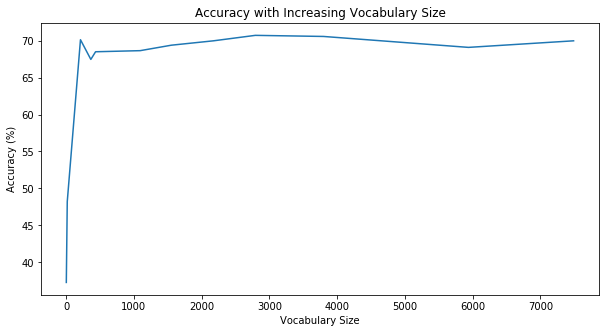

In [16]:
accuracy = []
vocab_size = []

def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###
    vectorizer = CountVectorizer()
    train_matrix = vectorizer.fit_transform(train_data)
    lr_l1 = LogisticRegression(penalty='l1')
    lr_l1.fit(train_matrix, train_labels)
    print("The number of raw non-zero weights per observation with l1 penalty is", np.sum(lr_l1.coef_ !=0))
    print("The number of non-zero learned weights with l1 penalty is", sum(np.any(lr_l1.coef_ != 0, axis=0)), "\n")
    lr_l2 = LogisticRegression(penalty='l2')
    lr_l2.fit(train_matrix, train_labels)
    print("The number of raw non-zero weights per observation with l2 penalty is", np.sum(lr_l2.coef_ !=0))
    print("The number of non-zero learned weights with l2 penalty is", sum(np.any(lr_l2.coef_ != 0, axis=0)))
    
    Cs = [0.001, 0.01, 0.1, 0.2, 0.25, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]
    
    for i in Cs:
        # Fit Log Reg with L1 and corresponding C value
        lr_l1 = LogisticRegression(penalty='l1', tol=.01, C = i)
        lr_l1.fit(train_matrix, train_labels)

        # Get index of features with at least one non-zero weight
        non_zero = np.any(lr_l1.coef_ != 0, axis=0)

        # Reduce vocabulary by keeping only features with non-zero weights
        reduced_vocab = np.array(vectorizer.get_feature_names())[non_zero]
        vocab_size.append(sum(non_zero))

        # Re-Vectorize training and dev data using reduced vocabulary
        new_vectorizer = CountVectorizer(vocabulary = reduced_vocab)
        new_train_matrix = new_vectorizer.transform(train_data)
        new_dev_matrix = new_vectorizer.transform(dev_data)

        # Re-fit Log Reg model with l2 penalty
        lr_l2 = LogisticRegression(penalty='l2')
        lr_l2.fit(new_train_matrix, train_labels)

        # Save model accuracy
        accuracy.append(lr_l2.score(new_dev_matrix, dev_labels))
        
    # Plot 
    plt.figure(figsize=(10, 5))
    plt.plot(vocab_size, np.array(accuracy)*100)
    plt.title("Accuracy with Increasing Vocabulary Size")
    plt.xlabel("Vocabulary Size")
    plt.ylabel("Accuracy (%)")
    plt.show()
    ### STUDENT END ###
P6()

ANSWER:

_Compared to l2 penalty, l1 penalty results in significantly less number of non-zero weights. l1 penalty produced 1743 non-zero weights while l2 penalty did not produce any weight equal to zero_

_The L2 penalty does not reduce the vocabulary size at all since it can not reduce any coefficients to exactly zero, rather only to small values. On the other hand, the L1 penalty reduces the size of the vocabulary significantly, and fairly steadily with increasing C values_

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [20]:
def P7():
### STUDENT START ###
    vectorizer = TfidfVectorizer()
    train_matrix = vectorizer.fit_transform(train_data)
    dev_matrix = vectorizer.transform(dev_data)
    
    lr = LogisticRegression(C=100)
    lr.fit(train_matrix, train_labels)
    
    # Get predicted probabilities
    pred_prob = lr.predict_proba(dev_matrix)
    print("Accuracy is",lr.score(dev_matrix, dev_labels))
    print("F1-score is", metrics.f1_score(dev_labels, lr.predict(dev_matrix), average='macro'), "\n")
    
    # Calculate R ratio
    r_ratios = np.amax(pred_prob, axis=1) / pred_prob[np.arange(len(dev_labels)),dev_labels]
    
    # Print 3 documents with largest R ratio
    for i in np.argsort(r_ratios)[-3:]:
        #print(i)
        #print(categories) 
        #print(newsgroups_train.target_names)
        #print("Actual Category:\t\t  %s " % categories[dev_labels[i]])
        print("Actual Category:\t\t  %s " % newsgroups_train.target_names[dev_labels[i]])
        #print("Predicted Category:\t\t  %s " % categories[np.argmax(pred_prob[i,:])])
        print("Predicted Category:\t\t  %s " % newsgroups_train.target_names[np.argmax(pred_prob[i,:])])
        print("R ratio:\t\t\t  %0.2f" %  r_ratios[i])
        print("Predicted Probababilities:\t ",  pred_prob[i,:])
        print("Message:\n")
        print(dev_data[i], "\n")

    # Printing Confusion matrix
    np.set_printoptions()
    cm = confusion_matrix(lr.predict(dev_matrix), dev_labels)
    print(newsgroups_train.target_names)
    print(cm)
    
## STUDENT END ###
P7()

Accuracy is 0.7633136094674556
F1-score is 0.7473913101645842 

Actual Category:		  alt.atheism 
Predicted Category:		  talk.religion.misc 
R ratio:			  287.31
Predicted Probababilities:	  [0.00242063 0.020071   0.28204529 0.69546308]
Message:


The 24 children were, of course, killed by a lone gunman in a second story
window, who fired eight bullets in the space of two seconds...
 

Actual Category:		  talk.religion.misc 
Predicted Category:		  comp.graphics 
R ratio:			  325.00
Predicted Probababilities:	  [0.00291176 0.97974505 0.01432863 0.00301456]
Message:

Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible. 

Actual Category:		  talk.religion.misc 
Predicted Category:		  comp.graphics 
R ratio:			  929.36
Predicted Probababilities:	  [0.00196657 0.99371901 0.00324517 0.00106925]
Message:

I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mor

ANSWER:

CountVectorizer creates a matrix where each cell represents the number of times the feature has appeared in a document. Whereas, TfidfVectorizer creates a matrix where each cell represents the Tf-idf weight of each feature in the document.
Tf-idf of a feature is calculated in the following way: Term frequency X Inverse Document Frequency.
Term Frequency = number of times a word appeared in a document / total number of words in the document
Inverse Document Frequency = Log_e(total number of documents / number of documents in which the word appears).
Therefore, Tf-idf reduces the importance of common features.

What kind of mistakes is the model making:
As we can see from the Confusion Matrix, most errors are between 'talk.religion.misc' and 'alt.atheism'. From the label names it seems that words that are important to one label will be important to the other label as well. Hence the classifier is making errors. There are also several errors between 'comp.graphics' and 'alt.atheism'. The errors between 'comp.graphics' and 'alt.atheism' are caused by the presense of 'computer like' words such as internet, download and ftp.

Ways to address issues:
To solve errors between 'talk.religion.misc' and 'alt.atheism', we can do the following:

Remove stopwords
Use the max_df parameter to to set corpus specific stop words
to solve the errors between 'comp.graphics' and 'alt.atheism', we can do the following:

Use grammar recognition and give more weights to object of the sentences and less weight to other words.

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

In [23]:
def P8():
        
    cv = TfidfVectorizer(stop_words='english', max_df = 100)
    cv.fit(train_data)

    train_data_matrix = cv.transform(train_data)
    dev_data_matrix = cv.transform(dev_data)
    
    logit_clf = LogisticRegression(C=100, penalty='l2')
    logit_clf.fit(train_data_matrix, train_labels)
    logit_clf.preds = logit_clf.predict(dev_data_matrix)
    print("Accuracy of logistic Regression using TfidfVectorizer =", logit_clf.score(dev_data_matrix, dev_labels), "\n")
    
    # Printing Confusion matrix
    np.set_printoptions()
    cm = confusion_matrix(logit_clf.preds, dev_labels)
    print(newsgroups_train.target_names)
    print(cm)
    
P8()

Accuracy of logistic Regression using TfidfVectorizer = 0.7795857988165681 

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
[[ 98   3   8  20]
 [  5 166   7   9]
 [ 26  15 182  17]
 [ 36   1   2  81]]


From the confusion matrix in #P7 we see that the number of errors between 'talk.religion.misc' and 'alt.atheism' was 33 + 31 = 64 with an overall accuracy of 0.763313609467.
By applying english stopwords and corpus specific stop words (by using the max_df parameter), the errors between 'talk.religion.misc' and 'alt.atheism' has reduced to 36 + 19 = 55 and overall accuracy has increased to 0.781065088757